In [1]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [2]:
import numpy as np

In [3]:
import utils

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [5]:
from tqdm.keras import TqdmCallback

Using TensorFlow backend.


In [6]:
# generate fake data

In [515]:
class PrintDot(tf.keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for 
    each completed epoch.
    """

    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoc_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0:
            print("")
        print(".", end="")

In [516]:
def gen_data(npts=1000):
    x = np.linspace(0, 1, npts)
    y = x + x ** 2 * np.sin(x * 2 * np.pi / 0.5)
    return x.reshape(-1, 1), y.reshape(-1, 1)

In [533]:
X, y = gen_data(npts=10000)
# X, y = gen_data(npts=1000)

In [534]:
X.shape

(10000, 1)

In [535]:
y.shape

(10000, 1)

In [536]:
plt.figure()
plt.plot(X, y, "k.-")
plt.title("the data")

Text(0.5, 1.0, 'the data')

In [537]:
def Linf_loss(y_actual, y_pred):
    return tf.keras.backend.max(tf.keras.backend.abs(y_actual - y_pred))

In [538]:
def mean_squared_error_loss(y_actual, y_pred):
    """
    this is the tf.keras MSE
    """
    diff_sq = tf.keras.backend.square(y_actual - y_pred)
    return tf.keras.backend.mean(diff_sq, axis=-1)

In [539]:
class Model:
    def __init__(self):
        self.model = self.build_model()

        # init epoch counter
        self.epoch_counter = 0
        self.all_epochs = []
        self.all_histories = []

        # keep a list of all predictions after each training sessions
        self.all_yhats = []

    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=1, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(256, activation="relu"))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(1, activation="linear"))
        #         model.summary()
        return model

    def compile_model(self, learning_rate, loss_func):
        # opt = tf.keras.optimizers.Adam(learning_rate=1e-1)
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        # opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
        # opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
        # opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
        # opt = tf.keras.optimizers.Adam(learning_rate=1e-7)

        # model.compile(loss='mse', optimizer=opt)
        # model.compile(loss='mae', optimizer=opt, metrics=['mse'])
        # model.compile(loss=mean_squared_error_loss, optimizer=opt, metrics=['mse'])
        self.model.compile(loss=loss_func, optimizer=opt, metrics=["mse"])

    def train(self, X, y, epochs, verbose, callbacks, batch_size=None, full_X=None):
        self.history = self.model.fit(
            X,
            y,
            epochs=epochs,
            verbose=verbose,
            callbacks=callbacks,
            batch_size=batch_size,
        )
        self.all_epochs.append(range(self.epoch_counter, self.epoch_counter + epochs))
        self.all_histories.append(self.history)
        self.epoch_counter += epochs

        if full_X is not None:
            self.all_yhats.append(self.model.predict(full_X))
        else:
            self.all_yhats.append(self.model.predict(X))

    def make_full_history(self):
        self.full_epochs = np.concatenate([list(ep) for ep in self.all_epochs])
        self.full_history = np.concatenate(
            [list(hh.history["loss"]) for hh in self.all_histories]
        )

    def plot_history(self):
        fig = plt.figure()
        plt.plot(self.history.history["loss"], "k.-")
        plt.yscale("log")
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        return fig

In [541]:
# callbacks=[TqdmCallback(verbose=1)]
callbacks = [PrintDot()]

In [542]:
# model1.compile_model(learning_rate=1e-4, loss_func=Linf_loss)
# model1.compile_model(learning_rate=1e-6, loss_func='mse')

In [543]:
# model1.train(X, y, epochs=100, verbose=0, callbacks=callbacks)

In [544]:
def shuffle_data(X, y, size):
    Xy = np.array(list(zip(X[:, 0], y[:, 0])))
    X, y = tf.random.shuffle(Xy).numpy().T
    return X[:size][..., np.newaxis], y[:size][..., np.newaxis]

In [547]:
model1 = Model()

# loss_func=Linf_loss
loss_func = "mse"
batch_sizes = [None, None, 256, 512]
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
epochs = [250, 250, 250, 200]


# as we decrease the learning rate lets increase the training set size

ts_size = [len(X) // 100, len(X) // 10, len(X) // 5, len(X)]

Xfits = []
yfits = []
for size in ts_size:
    xtmp, ytmp = shuffle_data(X, y, size)
    Xfits.append(xtmp)
    yfits.append(ytmp)

In [548]:
%%time
for i in range(len(learning_rates)):
    print(f"\nworking {i}/{len(learning_rates)-1}")
    print(f"learning rate: {learning_rates[i]}")
    print(f"epochs: {epochs[i]}")
    print(f"training data size: {ts_size[i]}")
    print(f"batch_sizes: {batch_sizes[i]}")

    model1.compile_model(learning_rate=learning_rates[i], loss_func=loss_func)
    #     model1.train(Xfit, yfit, epochs=epochs[i], verbose=0, callbacks=callbacks, batch_size=batch_size)
    model1.train(
        Xfits[i],
        yfits[i],
        epochs=epochs[i],
        verbose=0,
        callbacks=callbacks,
        batch_size=batch_sizes[i],
        full_X=X,
    )

print("\n done!")


working 0/3
learning rate: 0.001
epochs: 200
training data size: 100
batch_sizes: None

....................................................................................................
....................................................................................................
working 1/3
learning rate: 0.0001
epochs: 250
training data size: 1000
batch_sizes: None

....................................................................................................
....................................................................................................
..................................................
working 2/3
learning rate: 1e-05
epochs: 250
training data size: 2000
batch_sizes: 256

....................................................................................................
....................................................................................................
..................................................
working 3/3
learning rate

In [549]:
model1.make_full_history()
fig = plt.figure()

plt.plot(model1.full_epochs, model1.full_history, "k.-")

for i in range(len(model1.all_epochs)):
    plt.plot(
        list(model1.all_epochs[i]),
        model1.all_histories[i].history["loss"],
        label=f"lr:{learning_rates[i]}",
    )


plt.axhline(0.00189)
plt.axhline(0.0009838, ls="--")

plt.axhline(1.337063e-08, ls=":")

plt.yscale("log")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

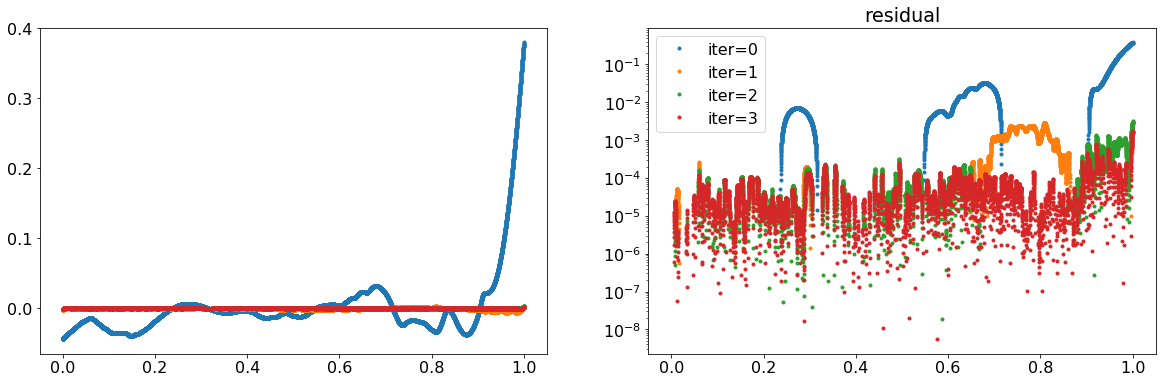

In [550]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, "k.")
for i, yhat in enumerate(model1.all_yhats):
    plt.plot(X, yhat, label=f"iter={i}")
plt.legend()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for i, yhat in enumerate(model1.all_yhats):
    axes[0].plot(X, y - yhat, ".", label=f"iter={i}")
    axes[1].plot(X, y - yhat, ".", label=f"iter={i}")
axes[1].set_yscale("log")
plt.title("residual")
plt.legend()